# Analyze sea-level predictions for Greenland by ISMIP6 and Aschwanden et al (2019) [AS19]

In [85]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [86]:
import numpy as np
import os
import pylab as plt
import pandas as pd
import seaborn as sns
import scipy

import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors

from utilities.data_loader import load_imbie_gris, load_ismip6_gris, load_imbie_ant, load_ismip6_ant
from utilities.helper import hist_start, hist_end, proj_start, proj_end, proj_time, secpera

import warnings
warnings.filterwarnings('ignore')

## Plotting helpers

In [87]:
fontsize = 8
lw = 0.65
aspect_ratio = 0.35
markersize = 2

params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


grace_signal_lw = 0.75
mouginot_signal_lw = 0.75
imbie_signal_lw = 0.75
simulated_signal_lw = 0.15
grace_signal_color = "#084594"
grace_sigma_color = "#9ecae1"
mouginot_signal_color = "#a63603"
mouginot_sigma_color = "#fdbe85"
imbie_signal_color = "#005a32"
imbie_sigma_color = "#a1d99b"
simulated_signal_color = "0.7"

gt2cmSLE = 1.0 / 362.5 / 10.0

rcp_list = [26, 85]
rcp_dict = {26: "RCP 2.6", 45: "RCP 4.5", 85: "RCP 8.5"}
rcp_col_dict = {85: "#990002", 45: "#5492CD", 26: "#003466"}
rcp_shade_col_dict = {85: "#F4A582", 45: "#92C5DE", 26: "#4393C3"}
model_ls_dict = {"Model Uncertainty (ISMIP6)": "solid", "Parametric Uncertainty (AS19)": "dashed"}


def set_size(w, h, ax=None):
    """ w, h: width, height in inches """

    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)



## Load ISMIP6 Greenland projections

In [88]:
ismip6_gris = load_ismip6_gris(remove_ctrl=True)
ismip6_gris_w_ctrl = load_ismip6_gris(remove_ctrl=False)

## ISMIP6 in numbers

In [89]:
ng = len(ismip6_gris.groupby(by="Group").mean())
nm = len(ismip6_gris.groupby(by="Model").mean())
ne = len(ismip6_gris.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

Number of modeling groups participated: 13
Number of ice sheet model configurations used: 18
Number of experiments: 9


## Load Observations

In [90]:
imbie_gris = load_imbie_gris()

## Plot function to reproduce Figure 1 in Aschwanden et al (2021)

In [91]:
def plot_historical(
    out_filename, df, imbie, x_lim=[2000, 2025], y_lim=[-3000, 4000], p_var="Cumulative ice sheet mass change (Gt)"
):
    """
    Plot historical simulations and observations.
    """

    def plot_signal(g):
        m_df = g[-1]
        x = m_df["Year"]
        y = m_df[p_var]

        return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)

    fig = plt.figure(num="historical", clear=True)
    ax = fig.add_subplot(111)

    [plot_signal(g) for g in df.groupby(by=["Group", "Model", "Exp"])]

    ismip6_mean = df.groupby(by="Year")[p_var].mean().dropna()
    ismip6_std = df.groupby(by="Year")[p_var].std()
    ismip6_low = df.groupby(by="Year")[p_var].quantile(0.05).dropna()
    ismip6_high = df.groupby(by="Year")[p_var].quantile(0.95).dropna()

    ismip6_ci = ax.fill_between(
        ismip6_mean.index,
        ismip6_low,
        ismip6_high,
        color="0.0",
        alpha=0.30,
        linewidth=0.0,
        zorder=10,
        label="Simulated (ISMIP6) 90% c.i.",
    )

    ax.fill_between(
        imbie["Year"],
        imbie[p_var] - 1 * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
        imbie[p_var] + 1 * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
        color=imbie_sigma_color,
        alpha=0.5,
        linewidth=0,
    )
    imbie_line = ax.plot(
        imbie["Year"],
        imbie[p_var],
        "-",
        color=imbie_signal_color,
        linewidth=imbie_signal_lw,
        label="Observed (IMBIE)",
    )

    ax.axvline(proj_start, color="k", linestyle="dashed", linewidth=grace_signal_lw)
    ax.axhline(0, color="k", linestyle="dotted", linewidth=grace_signal_lw)
    ax.text(2014.75, y_lim[-1] - 1000, "Historical Period", ha="right")
    ax.text(2015.25, y_lim[-1] - 1000, "Projection Period", ha="left")

    model_line = mlines.Line2D(
        [], [], color=simulated_signal_color, linewidth=simulated_signal_lw, label="Simulated (ISMIP6)"
    )

    legend = ax.legend(handles=[imbie_line[0], model_line, ismip6_ci], loc="lower left")
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)

    ax.set_xlabel("Year")
    ax.set_ylabel(f"Cumulative mass change\nsince {proj_start} (Gt)")

    ax.set_xlim(x_lim[0], x_lim[-1])
    ax.set_ylim(y_lim[0], y_lim[-1])
    ax_sle = ax.twinx()
    ax_sle.set_ylabel(f"Contribution to sea-level \nsince {proj_start} (cm SLE)")
    ax_sle.set_ylim(-y_lim[0] * gt2cmSLE, -y_lim[-1] * gt2cmSLE)

    set_size(5, 2.5)

    fig.savefig(out_filename, bbox_inches="tight")


## Plot the historical simulations along side observations

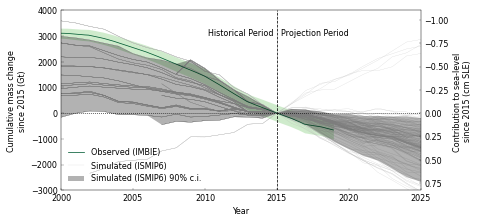

In [92]:
historical_filename = "GRIS_historical_w_ctrl.pdf"
plot_historical(historical_filename, ismip6_gris_w_ctrl, imbie_gris)

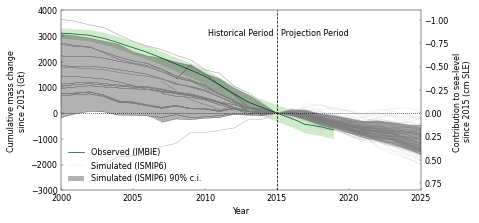

In [93]:
historical_filename = "GRIS_historical.pdf"
plot_historical(historical_filename, ismip6_gris, imbie_gris)

Unfortunately, most simulations underestimate recent (2008--2020) mass loss. Indeed, the observed record of mass loss lies beyond the 95th percentile of the ISMIP6 experiments. Underestimating recent mass loss likely translates into underestimating mass loss at 2100 as well.  That observations and the ensemble are disjoint implies that model uncertainty is underestimated both now and in the future. 

## Comparison between model and parametric uncertainty

Let us now compare model uncertainty and parametric uncertainty. Here we will use the 500 member ensemble of Aschwanden et al. (2019) [AS19]. We start by loading the AS19 data set.

In [94]:
as19_norm = pd.read_csv("as19/aschwanden_et_al_2019_les_2015_norm.csv.gz")
as19_norm["SLE (cm)"] = -as19_norm["Mass (Gt)"] / 362.5 / 10
as19_norm = as19_norm.astype({"RCP": int, "Experiment": int})

samples_file = "lhs_samples/lhs_samples_500.csv"
samples = pd.read_csv(samples_file).rename(columns={"id": "Experiment"})

as19_norm = pd.merge(as19_norm, samples, on="Experiment")


In [95]:
ismip6_ant = load_ismip6_ant(remove_ctrl=True)
ismip6_ant_w_ctrl = load_ismip6_ant(remove_ctrl=False)

ismip6_ant_ctrl_removed.csv.gz not found locally. Downloading the ISMIP6 archive.
   ...and converting to CSV
      Year  Cumulative ice sheet mass change (Gt) Group  Model    Exp RCP
0   2006.0                           1.694365e+12   AWI  PISM1  exp01  85
1   2007.0                           1.239098e+12   AWI  PISM1  exp01  85
2   2008.0                           1.331440e+12   AWI  PISM1  exp01  85
3   2009.0                           9.169755e+11   AWI  PISM1  exp01  85
4   2010.0                           1.013612e+12   AWI  PISM1  exp01  85
..     ...                                    ...   ...    ...    ...  ..
81  2097.0                           2.655524e+16   VUW   PISM  exp04  85
82  2098.0                           2.654907e+16   VUW   PISM  exp04  85
83  2099.0                           2.654237e+16   VUW   PISM  exp04  85
84  2100.0                           2.653568e+16   VUW   PISM  exp04  85
85  2101.0                           2.652822e+16   VUW   PISM  exp04  85

[

In [96]:
remove_ctrl = True
from netCDF4 import Dataset as NC
basedir = "ComputedScalarsPaper"
from pathlib import Path


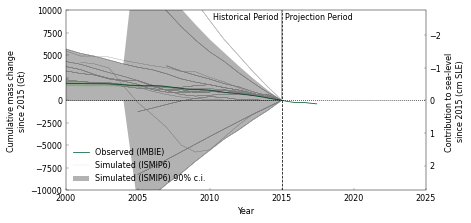

In [97]:
historical_filename = "AIS_historical.pdf"
imbie_ant = load_imbie_ant()
plot_historical(historical_filename, ismip6_ant, imbie_ant, y_lim=[-10000, 10000])

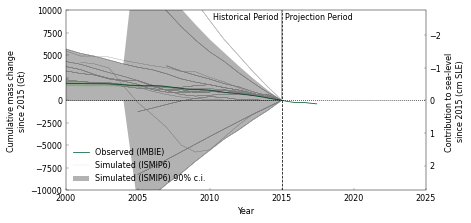

In [98]:
historical_filename = "AIS_historical_w_ctrl.pdf"
imbie_ant = load_imbie_ant()
plot_historical(historical_filename, ismip6_ant_w_ctrl, imbie_ant, y_lim=[-10000, 10000])

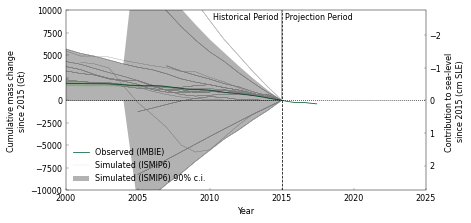

In [99]:
historical_filename = "AIS_historical_w_ctrl.pdf"
imbie_ant = load_imbie_ant()
plot_historical(historical_filename, ismip6_ant_w_ctrl, imbie_ant, y_lim=[-10000, 10000])

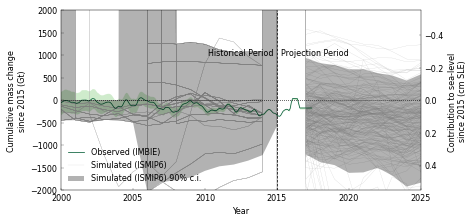

In [100]:
historical_filename = "AIS_historical_rates_w_ctrl.pdf"
imbie_ant = load_imbie_ant()
plot_historical(historical_filename, ismip6_ant_w_ctrl, imbie_ant, y_lim=[-2000, 2000], p_var="Rate of ice sheet mass change (Gt/yr)")

In [101]:
ismip6_ant_w_ctrl[(ismip6_ant_w_ctrl["Year"] < 2018) & (ismip6_ant_w_ctrl["Year"] >= 2012)]

,Unnamed: 0,Year,Cumulative ice sheet mass change (Gt),Group,Model,Exp,RCP,Rate of surface mass balance anomaly (Gt/yr),Rate of ice sheet mass change (Gt/yr)
6,6,2012.0,8.813487e+02,AWI,PISM1,exp01,85,NaN,-2.931315e+02
7,7,2013.0,5.940798e+02,AWI,PISM1,exp01,85,NaN,-1.113900e+02
8,8,2014.0,6.585688e+02,AWI,PISM1,exp01,85,NaN,-2.970399e+02
9,9,2015.0,0.000000e+00,AWI,PISM1,exp01,85,NaN,1.247331e+07
10,0,2016.0,2.494728e+07,AWI,PISM1,exp01,85,NaN,1.247355e+07
...,...,...,...,...,...,...,...,...,...
39223,13,2013.5,NaN,VUW,PISM,exp04,85,-60.977574,NaN
39224,14,2014.5,NaN,VUW,PISM,exp04,85,0.000000,NaN
39225,0,2015.5,NaN,VUW,PISM,exp04,85,2470.733425,NaN
39226,1,2016.5,NaN,VUW,PISM,exp04,85,2438.091383,NaN


In [102]:
ismip6_ant_w_ctrl[(ismip6_ant["Year"] < 2018) & (ismip6_ant["Year"] >= 2012)]

,Unnamed: 0,Year,Cumulative ice sheet mass change (Gt),Group,Model,Exp,RCP,Rate of surface mass balance anomaly (Gt/yr),Rate of ice sheet mass change (Gt/yr)
6,6,2012.0,8.813487e+02,AWI,PISM1,exp01,85,NaN,-2.931315e+02
7,7,2013.0,5.940798e+02,AWI,PISM1,exp01,85,NaN,-1.113900e+02
8,8,2014.0,6.585688e+02,AWI,PISM1,exp01,85,NaN,-2.970399e+02
9,9,2015.0,0.000000e+00,AWI,PISM1,exp01,85,NaN,1.247331e+07
10,0,2016.0,2.494728e+07,AWI,PISM1,exp01,85,NaN,1.247355e+07
...,...,...,...,...,...,...,...,...,...
39223,13,2013.5,NaN,VUW,PISM,exp04,85,-60.977574,NaN
39224,14,2014.5,NaN,VUW,PISM,exp04,85,0.000000,NaN
39225,0,2015.5,NaN,VUW,PISM,exp04,85,2470.733425,NaN
39226,1,2016.5,NaN,VUW,PISM,exp04,85,2438.091383,NaN


In [103]:
ism

NameError: name 'ism' is not defined

In [ ]:
S_time